LIbraries, global variables, and global functions:

In [1]:
# Import libraries:
import pandas as pd
import os
import seaborn as so
import matplotlib.pyplot as plt
# Graph output styling from matplotlib:
plt.style.use('fivethirtyeight')

# Global variables:
repo_dir = os.getcwd()  # Directory of the script
merged_data_dir = os.path.join(repo_dir, "Merged Data")   # Path to the Merged Data folder
export_dir = os.path.join(repo_dir, "Summary Tables")     # Path to the Summary Data folder
player_export_dir = os.path.join(export_dir, "Player Data") # Path to player data within Summary Data Folder
league_ids = ['ENG-Premier League', 'ESP-La Liga', 'FRA-Ligue 1', 'GER-Bundesliga', 'ITA-Serie A'] # For league-level iteration
season_ids = ['1718', '1819', '1920', '2021', '2122', '2223'] # For season-level iteration

In [2]:
# Create a statistics dictionary for the DEF category:
def_stat_dict = {'Tkl': 'mean',        # total tackles
                  'TklW': 'mean',      # total tackles won
                  'Def 3rd': 'mean',   # total tackles in def. 3rd
                  'Mid 3rd': 'mean',   # total tackles in mid. 3rd
                  'Blocks.1' : 'mean', # total blocks
                  'Sh.3': 'mean',     # total shots blocked
                  }

# Create a statistics dictionary for the MID category:
mid_stat_dict = {'Gls.1': 'mean',       # goals/90
                  'Ast.1': 'mean',      # assists/90
                  'G-PK.1': 'mean',     # npg per 90
                  'G+A-PK': 'mean',   # npg+a per 90
                  'npxG+xAG.1' : 'mean',
                  'SoT%': 'mean',
                  'Cmp%': 'mean',       # overall pass completion
                  'Cmp%.1': 'mean',     # mid-range pass completion
                  'SCA90': 'mean',
                  'GCA90': 'mean',
                  'Tkl%': 'mean',       # successful tackle rate
                  'PrgC.1': 'mean',     # total progressive carries
                  }

# Create a statistics dictionary for the FW category:
fw_stat_dict = {'Gls.1': 'mean',        # goals/90
                  'Ast.1': 'mean',      # assists/90
                  'G-PK.1': 'mean',     # npg per 90
                  'G+A-PK': 'mean',   # npg+a per 90
                  'npxG+xAG.1' : 'mean', # per 90
                  'npxG.1': 'mean',     # per 90
                  'G/Sh': 'mean',       # overall pass completion
                  'G/SoT': 'mean',      # mid-range pass completion
                  'np:G-xG': 'mean',    # per 90
                  'A-xAG': 'mean',      # total A - xAG 
                  'Crs': 'mean',        # total crosses
                  'GCA90': 'mean',
                  }

In [7]:
# Function that imports data from Github data folder:
def import_merged_data(file_path):
    df = pd.read_excel(file_path)
    return df


# Function that removes unnamed columns:
def remove_unnamed_cols(df):

    # Create list of unnamed columns:
    columns = df.columns
    unnamed_cols = [col for col in columns if "Unnamed" in col]

    # Create a new df and set index:
    new_df = (df
              .drop(columns=unnamed_cols)
              .set_index('league')
              )

    return new_df


# Function that writes the output data to an Excel file:
def make_xl(path, df, file_name):
    file_path = os.path.join(path, f'{file_name}.xlsx')
    return df.to_excel(file_path, index=True)           # Remove index=True if getting permission error


# Function that generates a dataframe with team-level statistics filtered by position and season:
def key_stats_table(df, stat_dict, pos, season):
    return (df[df['position'].str.contains(pos) & (df['season'] == season)]
              .groupby('team')
              .aggregate(stat_dict)
              .round(2) # Round averages to two decimal places
              .reset_index()
              )


# Function that generates a dataframe with season-team-level statistics filtered by position:
def key_stats_table_all_seasons(df, stat_dict, pos):
    return (df[df['position'].str.contains(pos)]
              .groupby(['season', 'team'])
              .aggregate(stat_dict)
              .round(2) # Round averages to two decimal places
              .reset_index()
              )


# Function that generates a dataframe with season-player-level statistics filtered by position:
def key_player_stats_all_seasons(df, stat_dict, pos):
    return (df[df['position'].str.contains(pos)]
              .groupby(['season', 'player'])
              .aggregate(stat_dict)
              .round(2) # Round averages to two decimal places
              .reset_index()
              )

Import the data into a list of 5 clean dataframes:

In [4]:
# Make a list of imported dataframes:
league_df_list = [import_merged_data(os.path.join(merged_data_dir, f"{league}_full_merge.xlsx")) for league in league_ids]

# Make a list of clean, copied dataframes:
cleaned_league_df_list = [remove_unnamed_cols((league_df.copy(deep=True))).dropna(subset=['position']) for league_df in league_df_list]

In [5]:
# Variables for iteration:
positions = ['DF', 'MF', 'FW']
seasons = [1718, 1819, 1920, 2021, 2122, 2223]
stat_dicts = [def_stat_dict, mid_stat_dict, fw_stat_dict]

In [8]:
# Create a season-player level stats table for each league:
for pos, stat_dict in zip(positions, stat_dicts):

    # File destination path:
    pos_export_dir = os.path.join(player_export_dir, pos)

    # Create a list of summary statistics table for each league for the position in the loop:
    stat_df_list = [key_player_stats_all_seasons(clean_league_df, stat_dict, pos) for clean_league_df in cleaned_league_df_list]

    # Send the summary tables to their respective directories:
    # for df, league in zip(stat_df_list, league_ids):
    #     make_xl(pos_export_dir, df, file_name=f"{league}_{pos}_player_keystats")

Generate some data visualizations without the transfer value data:

<AxesSubplot: xlabel='npxG+xAG.1', ylabel='G+A-PK'>

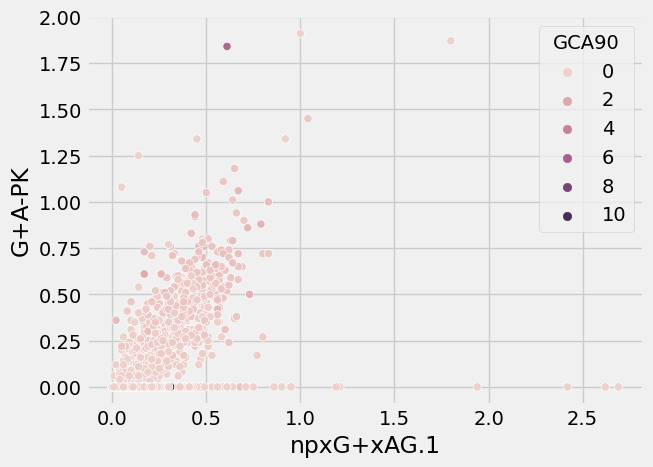

In [21]:
# Scatterplot of overall npxG+npxAG vs. G+A-PK per 90 for EPL midfielders:

# Import data from Player Data directory:
epl_mid_df = pd.read_excel(os.path.join(player_export_dir, "MF\ENG-Premier League_MF_player_keystats.xlsx")).drop(columns='Unnamed: 0')

# Create graphic:
so.scatterplot(data=epl_mid_df, x="npxG+xAG.1", y="G+A-PK", hue="GCA90")


In [20]:
epl_mid_df

,season,player,Gls.1,Ast.1,G-PK.1,G+A-PK,npxG+xAG.1,SoT%,Cmp%,Cmp%.1,SCA90,GCA90,Tkl%,PrgC.1
0,1718,Aaron Lennon,0.00,0.08,0.00,0.08,0.08,32.5,66.45,77.25,1.68,0.29,16.9,21.5
1,1718,Aaron Mooy,0.12,0.09,0.09,0.18,0.18,21.4,74.00,85.60,2.61,0.21,41.8,55.0
2,1718,Aaron Ramsey,0.34,0.39,0.34,0.73,0.56,44.6,83.40,88.70,3.07,0.63,18.2,61.0
3,1718,Abdelhamid Sabiri,0.00,0.41,0.00,0.41,0.17,0.0,66.00,69.00,3.27,0.41,14.3,2.0
4,1718,Abdoulaye Doucouré,0.19,0.08,0.19,0.27,0.16,36.2,82.70,86.10,2.68,0.19,34.2,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,2223,Wout Weghorst,0.00,0.11,0.00,0.11,0.36,35.7,72.90,78.50,3.05,0.23,22.2,3.0
1427,2223,Yasin Ayari,0.00,0.00,0.00,0.00,0.21,0.0,87.00,83.30,5.37,0.00,0.0,0.0
1428,2223,Youri Tielemans,0.12,0.08,0.08,0.15,0.21,27.6,80.30,88.70,2.99,0.15,37.7,35.0
1429,2223,Yves Bissouma,0.00,0.00,0.00,0.00,0.06,0.0,90.90,95.20,2.58,0.09,28.6,14.0
